In [46]:
import sys
import os
import shutil
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
import scipy
from skimage import io
# from scipy import ndimage
from IPython.display import display
%matplotlib inline
import scipy.io
import json

# Predicting Flower Categories using a pre-trained ResNet50

This project will be carried out in two notebooks:

```1.data_exploration.ipynb```   
```2.transfer_learning_resnet50.ipynb```

the first one (the current) will be on data exploration where we will investigate the dataset,   
and the second one will be on training/fine tuning the model ResNet50 for our current problem.

The dataset is downloaded from the link into the ```/data``` folder, where later the manipulated dataset and labels will be saved as well.   

## 1. Data Exploration

In this section, we will have a look at a few images of the main dataset and the dataset containing already segmented images. 

One interesting thing to observe is that images are of different size. Before training, they should be made into equal sizes.   

### Inspecting Images

In [2]:
# list of images in the dataset 
path_to_images = "data/jpg/"
file_names = sorted(os.listdir(path_to_images))

In [3]:
len(file_names)

8189

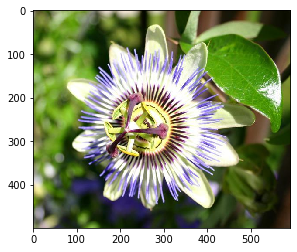

In [4]:
# show a single image as an example 
path_to_single_image = path_to_images + file_names[0] 
single_image = io.imread(path_to_single_image)
plt.imshow(single_image);

In [5]:
single_image.shape

(500, 591, 3)

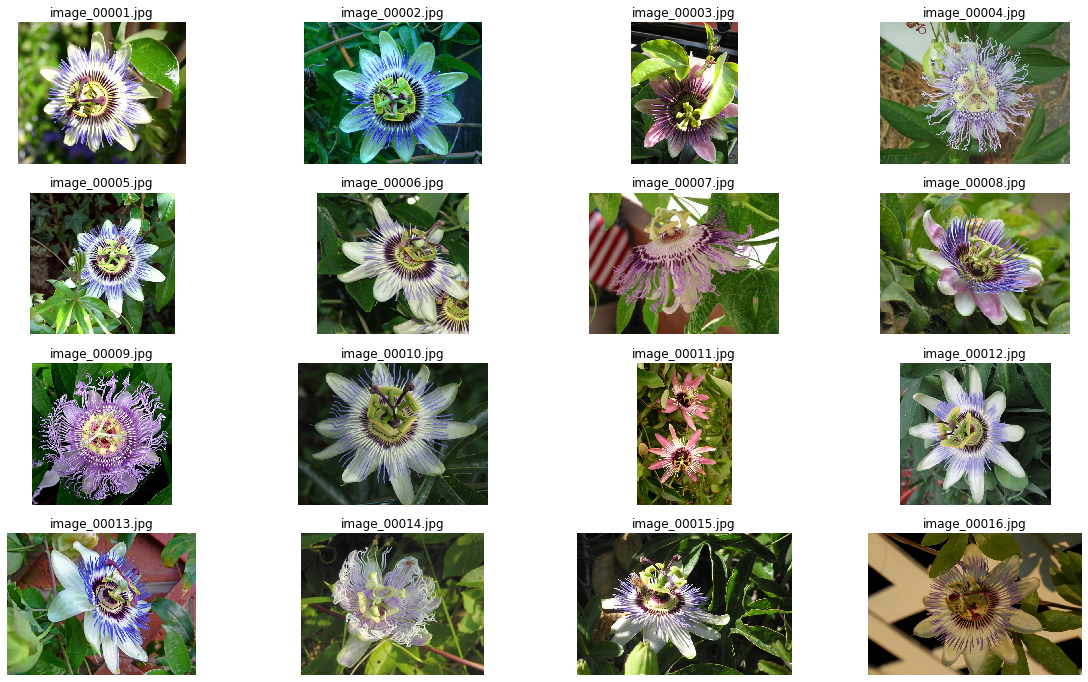

In [6]:
# plot a few images 
fig = plt.figure(figsize=[20, 12])
index = 0
for file_name in file_names[:16]:
    path_to_file = path_to_images + file_name
    single_image = io.imread(path_to_file)
    plt.subplot(4, 4, index+1)
    plt.imshow(single_image)
    plt.title("%s" % (file_name), fontsize=12)
    plt.axis('off') 
    index = index + 1

In [7]:
# it seems that the images are of different sizes. let's investigate the first 20 images: 
path_to_files_list = [path_to_images + file_name for file_name in file_names[:20]]
image_sizes = [io.imread(path_to_a_file).shape for path_to_a_file in path_to_files_list]

In [8]:
image_sizes

[(500, 591, 3),
 (500, 625, 3),
 (667, 500, 3),
 (500, 667, 3),
 (500, 508, 3),
 (500, 535, 3),
 (500, 667, 3),
 (500, 667, 3),
 (510, 500, 3),
 (500, 667, 3),
 (748, 500, 3),
 (500, 530, 3),
 (500, 666, 3),
 (500, 645, 3),
 (500, 755, 3),
 (500, 752, 3),
 (500, 531, 3),
 (500, 751, 3),
 (500, 667, 3),
 (501, 762, 3)]

In [9]:
# list of images in the segmented dataset 
path_to_segmented_images = "data/segmim/"
file_names_segmim = sorted(os.listdir(path_to_segmented_images))

In [10]:
len(file_names_segmim)

8189

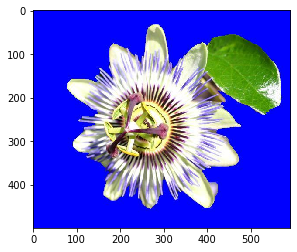

In [11]:
# show a single image as an example 
path_to_single_segmented_im = path_to_segmented_images + file_names_segmim[0] 
single_segmented_image = io.imread(path_to_single_segmented_im)
plt.imshow(single_segmented_image);

In [12]:
single_segmented_image.shape

(500, 591, 3)

In [13]:
file_names_segmim[0]

'segmim_00001.jpg'

<br><br/>

### Inspecting Image Labels

Here we inspect the provided image labels. They are given in a Matlab file format, which can be read using ```scipy``` package.\
The labels are in a dictionary containing other information that we don't need, so we will extract only the labels \
(being careful of keeping their order as each correspond to image names in order). 

Then we will check how many different labels there are and their total number, as well as the distribution of labels to see whether we have a class imbalance or not.

The histogram below indeed shows that some classes have much more examples than others. This means that we may have to use other metrics in addition to accuracy\
to assess the performance of our classification model.



In [14]:
image_labels = scipy.io.loadmat('data/imagelabels.mat')

In [15]:
image_labels

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 15:43:33 2009',
 '__version__': '1.0',
 '__globals__': [],
 'labels': array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)}

In [16]:
type(image_labels)

dict

In [30]:
image_labels["labels"]

array([[77, 77, 77, ..., 62, 62, 62]], dtype=uint8)

In [18]:
print (len(image_labels["labels"]))
print (type(image_labels["labels"]))

1
<class 'numpy.ndarray'>


In [19]:
image_labels_clean = image_labels["labels"][0]
print ("number of labels:", len(image_labels_clean))
print ("unique labels: \n", np.unique(image_labels_clean))

number of labels: 8189
unique labels: 
 [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102]


In [20]:
image_labels_clean[:10]

array([77, 77, 77, 77, 77, 77, 77, 77, 77, 77], dtype=uint8)

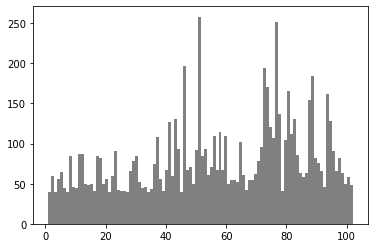

In [21]:
plt.hist(image_labels_clean, bins=102, color='gray');

In [22]:
unique_labels, frequency_labels = np.unique(image_labels_clean, return_counts = True)

In [23]:
print ("minimum number of examples for a certain label:", min(frequency_labels))
print ("maximum number of examples for a certain label:", max(frequency_labels))
print ("std of labels:", np.std(frequency_labels))

minimum number of examples for a certain label: 40
maximum number of examples for a certain label: 258
std of labels: 44.059313286456536


<br><br/>

<br><br/>

### Inspecting Data Splits

In the file ```setid.mat```, the image ids in the train/validation/test split are given. We will look at the number of images in each dataset\ 
(confirm that the numbers indeed match with the ones mentioned in the paper). According to this information on how the dataset is split,\
we will look at the distribution of labels in the training and validation sets. In both cases, the images are equally distributed among labels\
each class having ten examples. This means during training, we do not need to treat the problem as an imbalanced class problem (i.e. we do not have to sample/oversample)\
but since before we found out that labels overall weren't equally distrubuted, the test set must have the imbalance, therefore we need to use a few more metrics\
in addition to overall accuracy after testing our model. 

Here, we will also save the labels of test data in a dictionary format in a json file. This dictionary will have keys as segmented image names and their values as the labels.  

In [24]:
data_splits = scipy.io.loadmat('data/setid.mat')

In [25]:
data_splits

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Thu Feb 19 17:38:58 2009',
 '__version__': '1.0',
 '__globals__': [],
 'trnid': array([[6765, 6755, 6768, ..., 8026, 8036, 8041]], dtype=uint16),
 'valid': array([[6773, 6767, 6739, ..., 8028, 8008, 8030]], dtype=uint16),
 'tstid': array([[6734, 6735, 6737, ..., 8044, 8045, 8047]], dtype=uint16)}

In [26]:
print (len(data_splits["trnid"][0]))
print (len(data_splits["valid"][0]))
print (len(data_splits["tstid"][0]))

1020
1020
6149


In [29]:
 data_splits['tstid'][0]

array([6734, 6735, 6737, ..., 8044, 8045, 8047], dtype=uint16)

In [50]:
# distribution of labels among train and validation sets:
labels_train_valid_test = {'trnid': [], 'valid': [], 'tstid': []}
labels_test_dict = {}
for id_ in ["trnid", "valid", 'tstid']:
    for file_number in data_splits[id_][0]:
        file_label = image_labels_clean[file_number-1]
        labels_train_valid_test[id_].append(file_label)
        if id_ == 'tstid':
            #labels_test_dict[str(file_number)] = str(file_label)
            labels_test_dict["segmim_" + "0"*(5-len(str(file_number))) + str(file_number) + ".jpg"] = str(file_label)

In [90]:
unique_labels_train, frequency_labels_train = np.unique(labels_train_valid_test['trnid'], return_counts = True)
unique_labels_val, frequency_labels_val = np.unique(labels_train_valid_test['valid'], return_counts = True)

In [91]:
frequency_labels_train

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [92]:
frequency_labels_val

array([10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10])

In [52]:
# extracting and saving test labels separately: 
json.dump(labels_test_dict, open("data/labels_test.json", 'w'))

In [96]:
len(labels_test)

6149

In [53]:
unique_labels_test, frequency_labels_test = np.unique(labels_train_valid_test['tstid'], return_counts = True)

In [54]:
frequency_labels_test

array([ 20,  40,  20,  36,  45,  25,  20,  65,  26,  25,  67,  67,  29,
        28,  29,  21,  65,  62,  29,  36,  20,  39,  71,  22,  21,  21,
        20,  46,  58,  65,  32,  25,  26,  20,  23,  55,  88,  36,  21,
        47, 107,  39, 110,  73,  20, 176,  47,  51,  29,  72, 238,  65,
        73,  41,  51,  89,  47,  94,  47,  89,  30,  35,  34,  32,  82,
        41,  22,  34,  34,  42,  58,  76, 174, 151, 100,  87, 231, 117,
        21,  85, 146,  92, 111,  66,  43,  38,  43, 134, 164,  62,  56,
        46,  26, 142, 108,  71,  46,  62,  43,  29,  38,  28])

<br><BR/>

### Saving Images to Train, Valid, Test Folders 

Here we create additional ```train```, ```val``` and ```test``` folders and save the corresponding segmented images in these folders separately.\
```PyTorch``` requires the training and validation data to be further in class folders inside training and validation folders; so we create class subfolders inside\
```train``` and ```val``` folders as well. Test files on the other hand are directly copied to ```test``` folder; we will use the labels we saved in json format\
in the previous subsection to assess the performance of the model. 

In [ ]:
# using segmented images
# saving images to train, valid, test folders. Pytorch requires to save the train/val files in their class folders already in advance 

In [83]:
# Providing the folder path
origin = "data/segmim/"
target_train = "data/train/"
target_valid = "data/val/"
target_test = "data/test/"
directories = {"trnid": target_train, "valid": target_valid, "tstid": target_test}
try:
    [os.mkdir(x) for x in [target_train, target_valid, target_test]];
except:
    print ("folders already exist")
       
# Fetching all the files to directory
for id_ in ["trnid", "valid"]:
    for file_number in data_splits[id_][0]:
        file_name = "segmim_" + "0"*(5-len(str(file_number))) + str(file_number) + ".jpg"
        file_label = str(image_labels_clean[file_number-1])
        class_dir = directories[id_] + file_label + "/"
        try:
            os.mkdir(class_dir)
        except:
            print ("class label folder already exists")
        shutil.copy(origin+file_name, class_dir+file_name) 

# copying test images separately 
for file_number in data_splits["tstid"][0]:
    file_name = "segmim_" + "0"*(5-len(str(file_number))) + str(file_number) + ".jpg"
    shutil.copy(origin+file_name, target_test+file_name) 
    
print("Files are copied successfully")

class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label folder already exists
class label fo